In [1]:
import json
import pprint
import matplotlib.pyplot as plt
import math
import statistics
import os

In [4]:
class DataExplorer():
    def __init__(self, organism_name):
        self.organism_name = organism_name
        
        # find protein links and protein info
        self.data_dir = "data"
        self.data_files = os.listdir(self.data_dir + "/{}/".format(organism_name))
        
        for file in self.data_files:
            if "links" in file: self.links_file = self.data_dir + "/{}/".format(organism_name) + file
                
        for file in self.data_files:
            if "info" in file: self.info_file = self.data_dir + "/{}/".format(organism_name) + file
        
        self.filtered_names, self.unfiltered_names = self.filter_protein_names(self.make_protein_names())   
        self.adj_list = self.make_adj_list(self.make_protein_links())
        
    def make_protein_links(self):
        with open(self.links_file) as file:
            lines = []
            for line in file:
                lines.append(line.split())
            protein_links = lines
        file.close()
        
        return protein_links[1:]
    
    def make_protein_names(self):
        with open(self.info_file) as file:
            lines = []
            for line in file:
                lines.append(line.split()[0:2])
            protein_names = lines
        file.close()
        
        return protein_names[1:]
    
    def filter_protein_names(self, protein_names):
        protein_names_filtered = {}
        protein_names_unfiltered = {}

        for name in protein_names:
            protein_id, pref_name = name
            protein_names_unfiltered[protein_id] = pref_name
            prefix = protein_id[int(protein_id.index(".")) + 1 : int(protein_id.index("_"))]

            if not pref_name.startswith(prefix):
                protein_names_filtered[protein_id] = pref_name
        return protein_names_filtered, protein_names_unfiltered
    
    def make_adj_list(self, protein_links):
        protein_links_dict = {}

        for link in protein_links:
            protein_1, protein_2, score = link

            if protein_1 not in protein_links_dict: 
                protein_links_dict[protein_1] = [(protein_2, round(int(score) / 1000, 7))]
            else:
                protein_links_dict[protein_1].append((protein_2, round(int(score) / 1000, 7)))
        
        return protein_links_dict

In [9]:
def make_plot(obj):
    f, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 5), gridspec_kw={'width_ratios': [1], 'height_ratios': [12, 4]})
    f.tight_layout()
    
    ilovephillip = plt.imread("compeau2.png")
    ax1.imshow(ilovephillip, extent=[1200,1600,600,900])
    
    # calculate average degree
    node_degrees = [len(obj.adj_list[i]) for i in obj.adj_list]
    degree_mean = sum(node_degrees) / len(node_degrees)
    
    # calculate graph density
    max_edges = int(len(obj.adj_list) * (len(obj.adj_list) - 1) / 2)
    number_edges = int(sum(node_degrees) / 2) # woah handshake lemma
    
    # calculate average score
    scores = []
    
    for prot in obj.adj_list:
        for interaction in obj.adj_list[prot]:
            scores.append(interaction[1])
    
    score_mean = sum(scores) / (2 * number_edges)
    
    n_bins = int(1 + 3.22 * math.log(len(node_degrees)))
    
    ax1.hist(node_degrees, bins = n_bins, alpha=0.8)
    ax1.set_title("PPI Network Degree Histogram ({})".format(obj.organism_name))
    ax1.set_xlabel("Node degrees")
    ax1.set_ylabel("Frequency")
    
    # ax2.set_title("PPI Network Statistics")
    ax2.axis('tight')
    ax2.axis('off')
    table = ax2.table(cellText = [[round(degree_mean, 3)],
                          [round(number_edges / max_edges, 3)], 
                          [round(score_mean, 3)]], 
              rowLabels=["Average degree", "Density ([0, 1])", "Average score ([0, 1])"], 
              loc='center', cellLoc='center', edges='open', colWidths=[0.3, 1])

    table.auto_set_font_size(False)
    table.set_fontsize(14)
    
    plt.savefig("{}-ppi-histogram.jpg".format(obj.organism_name), bbox_inches='tight', pad_inches=0.3)

In [12]:
def plot_datasets():
    subfolders = [f for f in os.scandir("data") if f.is_dir()]
    
    for orgsm in subfolders:
        orgsm_name = orgsm.name
        orgsm_explorer = DataExplorer(orgsm_name)
        
        make_plot(orgsm_explorer)

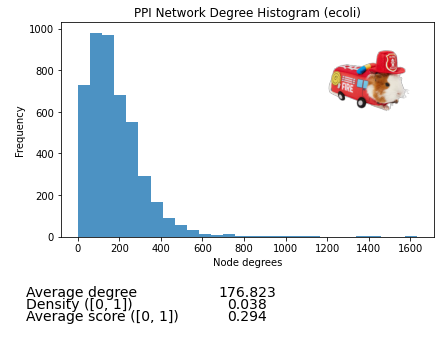

In [11]:
# plot_datasets()